In [56]:
from supervised_exp.fully_sup.dataset import get_dataset
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from utils.transformations import ShotNoise,AddGaussianNoise,Brightness

In [39]:
dataset = get_dataset(root_dir = "data/")
train_set,val_set,test_set,unlabel_set  = dataset["train_set"], dataset["val_set"],dataset["test_set"], \
dataset["unlabel_set"]

In [40]:
'''
Get mean and std of train_set
See Discussion Thread: https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/4
To get the mean and std, first concat unlabel and trainset for a more accurate calculation
'''


def calc_mean_std(dataloader,img_size=28):
    
    mean = 0.0
    
    for images, _ in dataloader:
        batch_samples = images.size(0) 
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        
    mean = mean / len(dataloader.dataset)

    var = 0.0
    for images, _ in dataloader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        var += ((images - mean.unsqueeze(1))**2).sum([0,2])
    std = torch.sqrt(var / (len(dataloader.dataset)*img_size*img_size))
    return mean,std

In [41]:
train_classes = [label.item() for _, label in train_set]
dist_train = Counter(train_classes)
print(f"Train Classes Distribution: {dist_train}")

unlabel_classes = [label.item() for _, label in unlabel_set]
dist_unlabel = Counter(unlabel_classes)
print(f"Unlabel Classes Distribution: {dist_unlabel}")

test_classes = [label.item() for _, label in test_set]
dist_test = Counter(test_classes)
print(f"Test Classes Distribution: {dist_test}")

Train Classes Distribution: Counter({8: 1275, 5: 1216, 2: 1067, 3: 1021, 0: 985, 1: 955, 7: 895, 6: 812, 4: 773})
Unlabel Classes Distribution: Counter({8: 11610, 5: 10966, 3: 9380, 2: 9293, 1: 8554, 7: 8506, 0: 8381, 4: 7233, 6: 7074})
Test Classes Distribution: Counter({0: 1338, 8: 1233, 4: 1035, 1: 847, 6: 741, 3: 634, 5: 592, 7: 421, 2: 339})


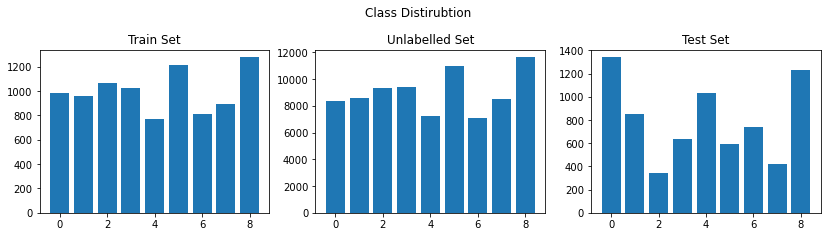

In [42]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(14,3))
fig.suptitle('Class Distirubtion',y= 1.08)
ax1.bar(dist_train.keys(),dist_train.values())
ax1.set_title("Train Set")
ax2.bar(dist_unlabel.keys(),dist_unlabel.values())
ax2.set_title("Unlabelled Set")
ax3.bar(dist_test.keys(),dist_test.values())
ax3.set_title("Test Set")
plt.savefig('images/class_dist.png')

In [43]:
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms as T
import torch
def unnormalize(tensor, mean =  [0.7405, 0.5330, 0.7058], std = [0.1237, 0.1768, 0.1244]):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def show(imgs,labels,fname = ""):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        if(len(labels) == len(imgs)): axs[0,i].set_xlabel(labels[i])
    
    if(len(fname) > 0):
        plt.savefig(f'images/{fname}.png')

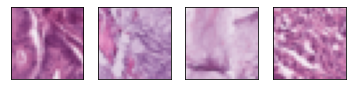

In [44]:
dataloader = DataLoader(test_set, batch_size=4,shuffle=False)
samples = iter(dataloader).next()
imgs = [unnormalize(sample) for sample in samples[0]]
images = np.load("data/test_images.npy")
show(imgs,"normal_img")

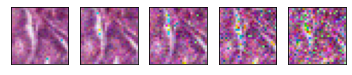

In [45]:
original = T.Compose([T.ToPILImage(),T.ToTensor(),
                     T.Normalize(mean =  [0.7405, 0.5330, 0.7058], std = [0.1237, 0.1768, 0.1244])])
transformations = {"original":original,
                  "blur": lambda x,y: T.GaussianBlur(kernel_size=(x,x), sigma=(y)),
                  "noise": lambda x,y: AddGaussianNoise(x,y)}

strengths = [0.05,0.07,0.09,0.13,0.15]
noises = [transformations["noise"]( 0,  (i)) for i in strengths]
imgs = [t(unnormalize(samples[0][0].clone())) for t in noises]
show(imgs,labels = list(transformations.keys()))

In [49]:
torch.norm(imgs[0]- unnormalize(original(samples[0][0])))

tensor(16.6020)

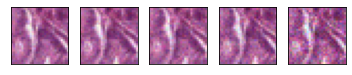

In [55]:
noises = [ShotNoise(i) for i in range(1,6)]
imgs = [unnormalize(transformations["original"](noise(images[0].copy()))) for noise in noises]
show(imgs,labels = list(transformations.keys()))

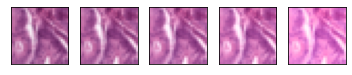

In [61]:
noises = [Brightness(i) for i in range(1,6)]
imgs = [unnormalize(transformations["original"](noise(images[0].copy()))) for noise in noises]
show(imgs,labels = list(transformations.keys()))